In [ ]:
!pip install defisheye

# 1. Load Images

In [3]:
# import required package

#!/usr/bin/env python3.6
# -*- Coding: UTF-8 -*-

import pandas as pd
import numpy as np
from PIL import Image
import os,datetime
from glob import glob
import cv2 as cv
import tensorflow as tf

# 2. Convert a fish-eye image to the flat image
\

In [ ]:
class Defisheye:
    """
    Defisheye

    fov: fisheye field of view (aperture) in degrees
    pfov: perspective field of view (aperture) in degrees
    xcenter: x center of fisheye area
    ycenter: y center of fisheye area
    radius: radius of fisheye area
    angle: image rotation in degrees clockwise
    dtype: linear, equalarea, orthographic, stereographic
    format: circular, fullframe
    """

    def __init__(self, infile, **kwargs):
        vkwargs = {"fov": 180,
                   "pfov": 120,
                   "xcenter": None,
                   "ycenter": None,
                   "radius": None,
                   "angle": 0,
                   "dtype": "equalarea",
                   "format": "fullframe"
                   }
        self._start_att(vkwargs, kwargs)

        if type(infile) == str:
            _image = cv.imread(infile)
        elif type(infile) == np.ndarray:
            _image = infile
        else:
            raise Exception("Image format not recognized")

        width = _image.shape[1]
        height = _image.shape[0]
        xcenter = width // 2
        ycenter = height // 2

        dim = min(width, height)
        x0 = xcenter - dim // 2
        xf = xcenter + dim // 2
        y0 = ycenter - dim // 2
        yf = ycenter + dim // 2

        self._image = _image[y0:yf, x0:xf, :]

        self._width = self._image.shape[1]
        self._height = self._image.shape[0]

        if self._xcenter is None:
            self._xcenter = (self._width - 1) // 2

        if self._ycenter is None:
            self._ycenter = (self._height - 1) // 2

    def _map(self, i, j, ofocinv, dim):

        xd = i - self._xcenter
        yd = j - self._ycenter

        rd = np.hypot(xd, yd)
        phiang = np.arctan(ofocinv * rd)

        if self._dtype == "linear":
            ifoc = dim * 180 / (self._fov * np.pi)
            rr = ifoc * phiang
            # rr = "rr={}*phiang;".format(ifoc)

        elif self._dtype == "equalarea":
            ifoc = dim / (2.0 * np.sin(self._fov * np.pi / 720))
            rr = ifoc * np.sin(phiang / 2)
            # rr = "rr={}*sin(phiang/2);".format(ifoc)

        elif self._dtype == "orthographic":
            ifoc = dim / (2.0 * np.sin(self._fov * np.pi / 360))
            rr = ifoc * np.sin(phiang)
            # rr="rr={}*sin(phiang);".format(ifoc)

        elif self._dtype == "stereographic":
            ifoc = dim / (2.0 * np.tan(self._fov * np.pi / 720))
            rr = ifoc * np.tan(phiang / 2)

        rdmask = rd != 0
        xs = xd.copy()
        ys = yd.copy()

        xs[rdmask] = (rr[rdmask] / rd[rdmask]) * xd[rdmask] + self._xcenter
        ys[rdmask] = (rr[rdmask] / rd[rdmask]) * yd[rdmask] + self._ycenter

        xs[~rdmask] = 0
        ys[~rdmask] = 0

        xs = xs.astype(int)
        ys = ys.astype(int)
        return xs, ys

    def convert(self, outfile=None):
        if self._format == "circular":
            dim = min(self._width, self._height)
        elif self._format == "fullframe":
            dim = np.sqrt(self._width ** 2.0 + self._height ** 2.0)

        if self._radius is not None:
            dim = 2 * self._radius

        # compute output (perspective) focal length and its inverse from ofov
        # phi=fov/2; r=N/2
        # r/f=tan(phi);
        # f=r/tan(phi);
        # f= (N/2)/tan((fov/2)*(pi/180)) = N/(2*tan(fov*pi/360))

        ofoc = dim / (2 * np.tan(self._pfov * np.pi / 360))
        ofocinv = 1.0 / ofoc

        i = np.arange(self._width)
        j = np.arange(self._height)
        i, j = np.meshgrid(i, j)

        xs, ys, = self._map(i, j, ofocinv, dim)
        img = self._image.copy()

        img[i, j, :] = self._image[xs, ys, :]
        if outfile is not None:
            cv.imwrite(outfile, img)
        return img

    def _start_att(self, vkwargs, kwargs):
        """
        Starting atributes
        """
        pin = []

        for key, value in kwargs.items():
            if key not in vkwargs:
                raise NameError("Invalid key {}".format(key))
            else:
                pin.append(key)
                setattr(self, "_{}".format(key), value)

        pin = set(pin)
        rkeys = set(vkwargs.keys()) - pin
        for key in rkeys:
            setattr(self, "_{}".format(key), vkwargs[key])

In [ ]:
dtype = 'linear'
format = 'fullframe'
fov = 180
pfov = 100
img_path = '/content/drive/MyDrive/Folsom_sky_images/2014/01/01/20140101_000011.jpg'

new_image = Defisheye(img_path, dtype=dtype, format=format, fov=fov, pfov=pfov).convert()

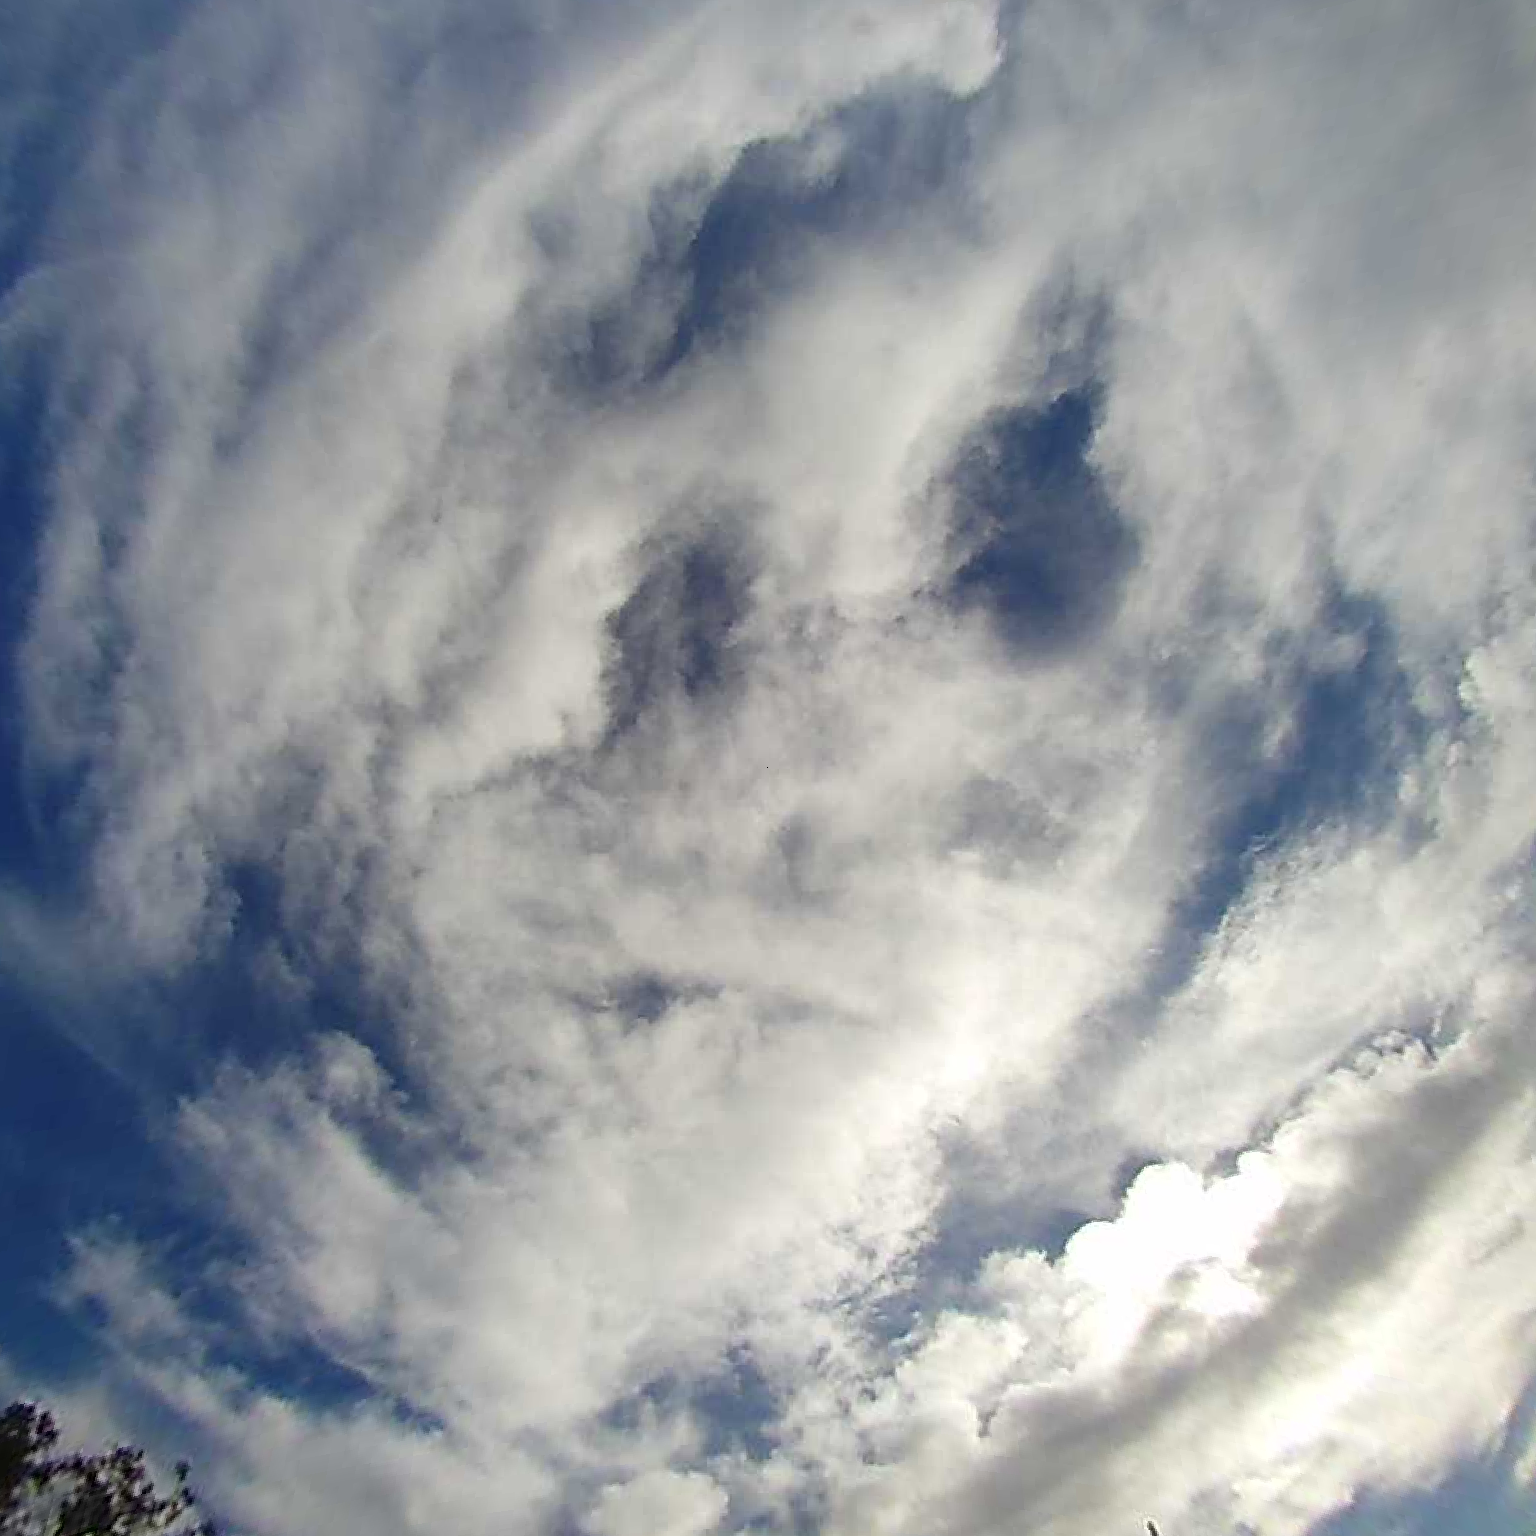

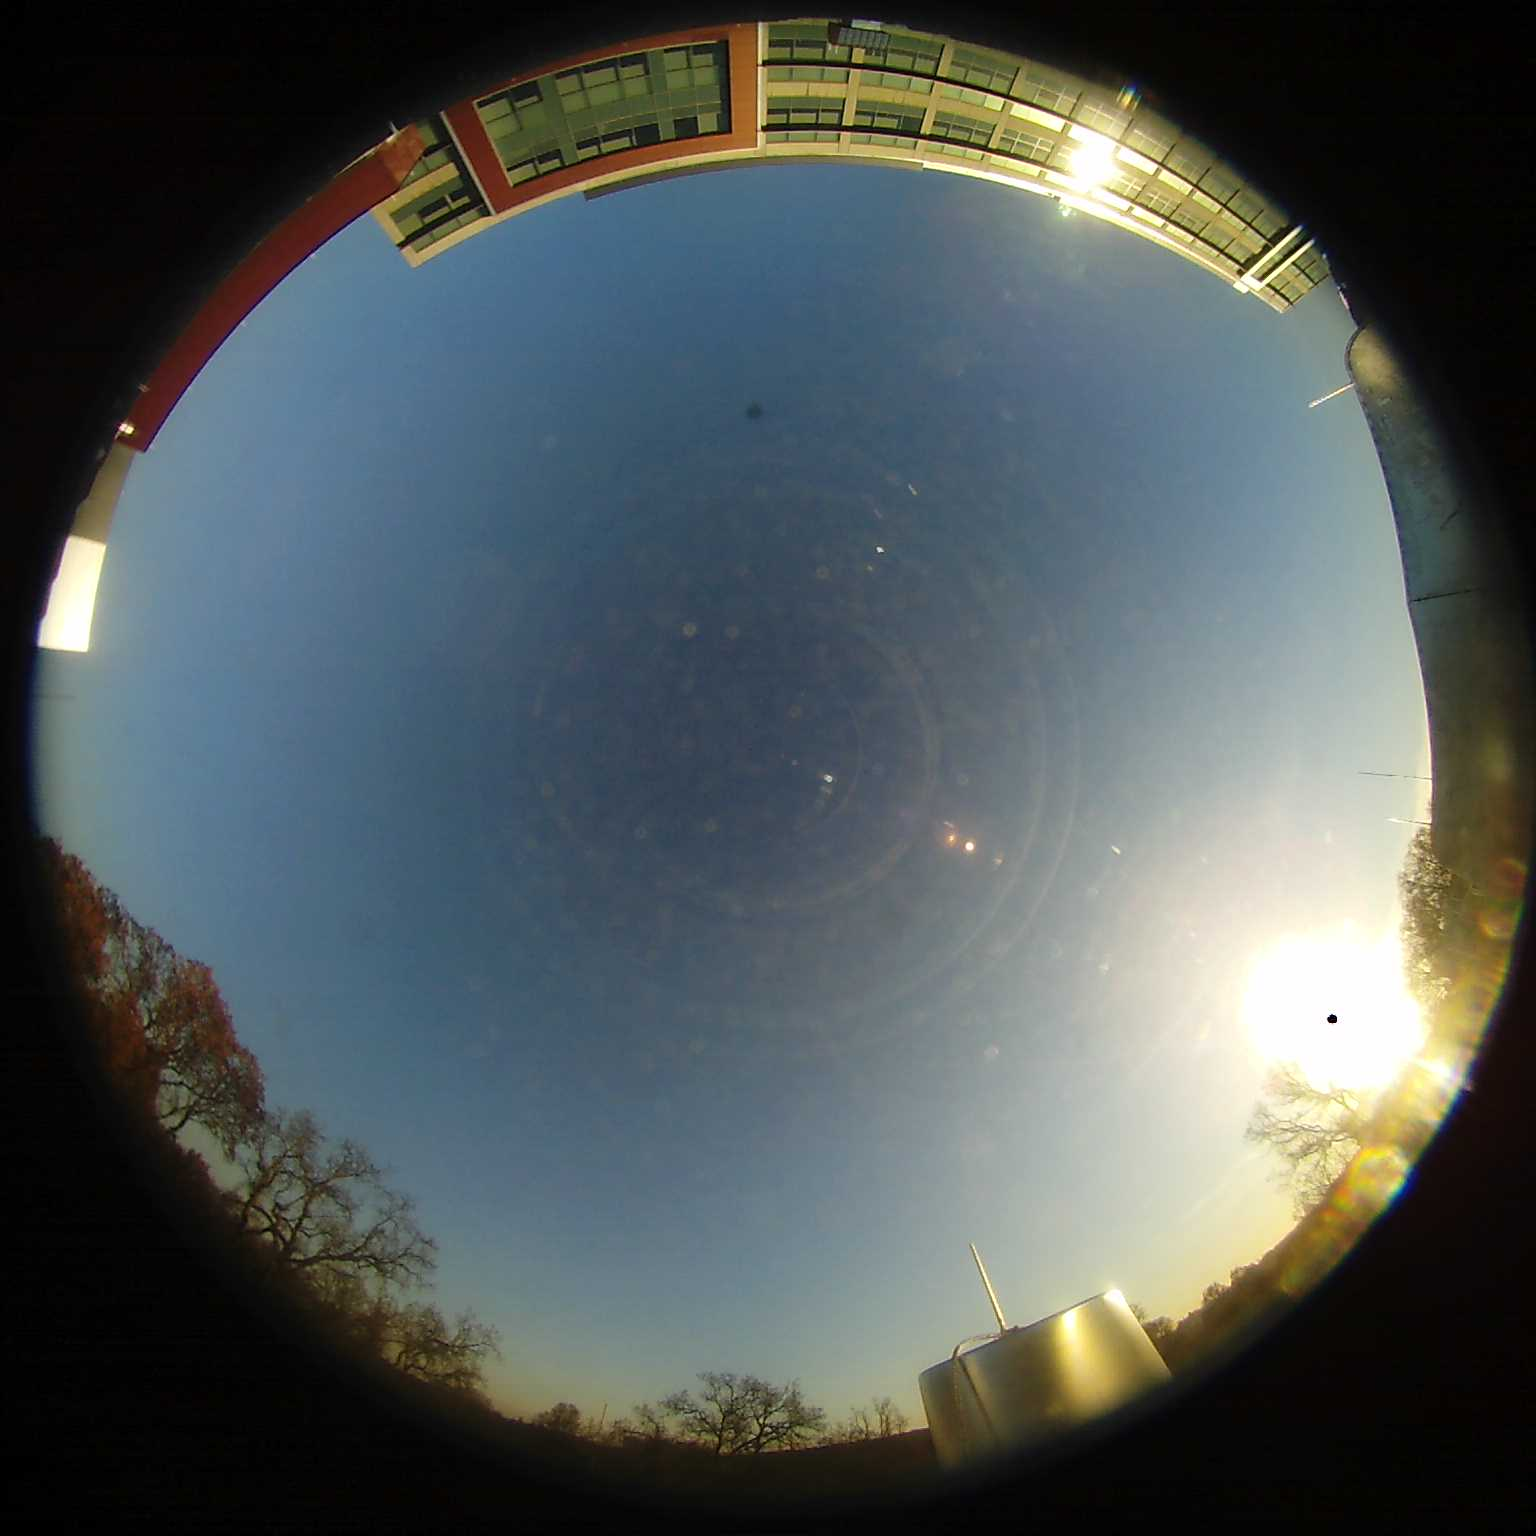

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(new_image)
cv2_imshow(cv.imread(img_path))

## 3. Convert the image into Color segmentation

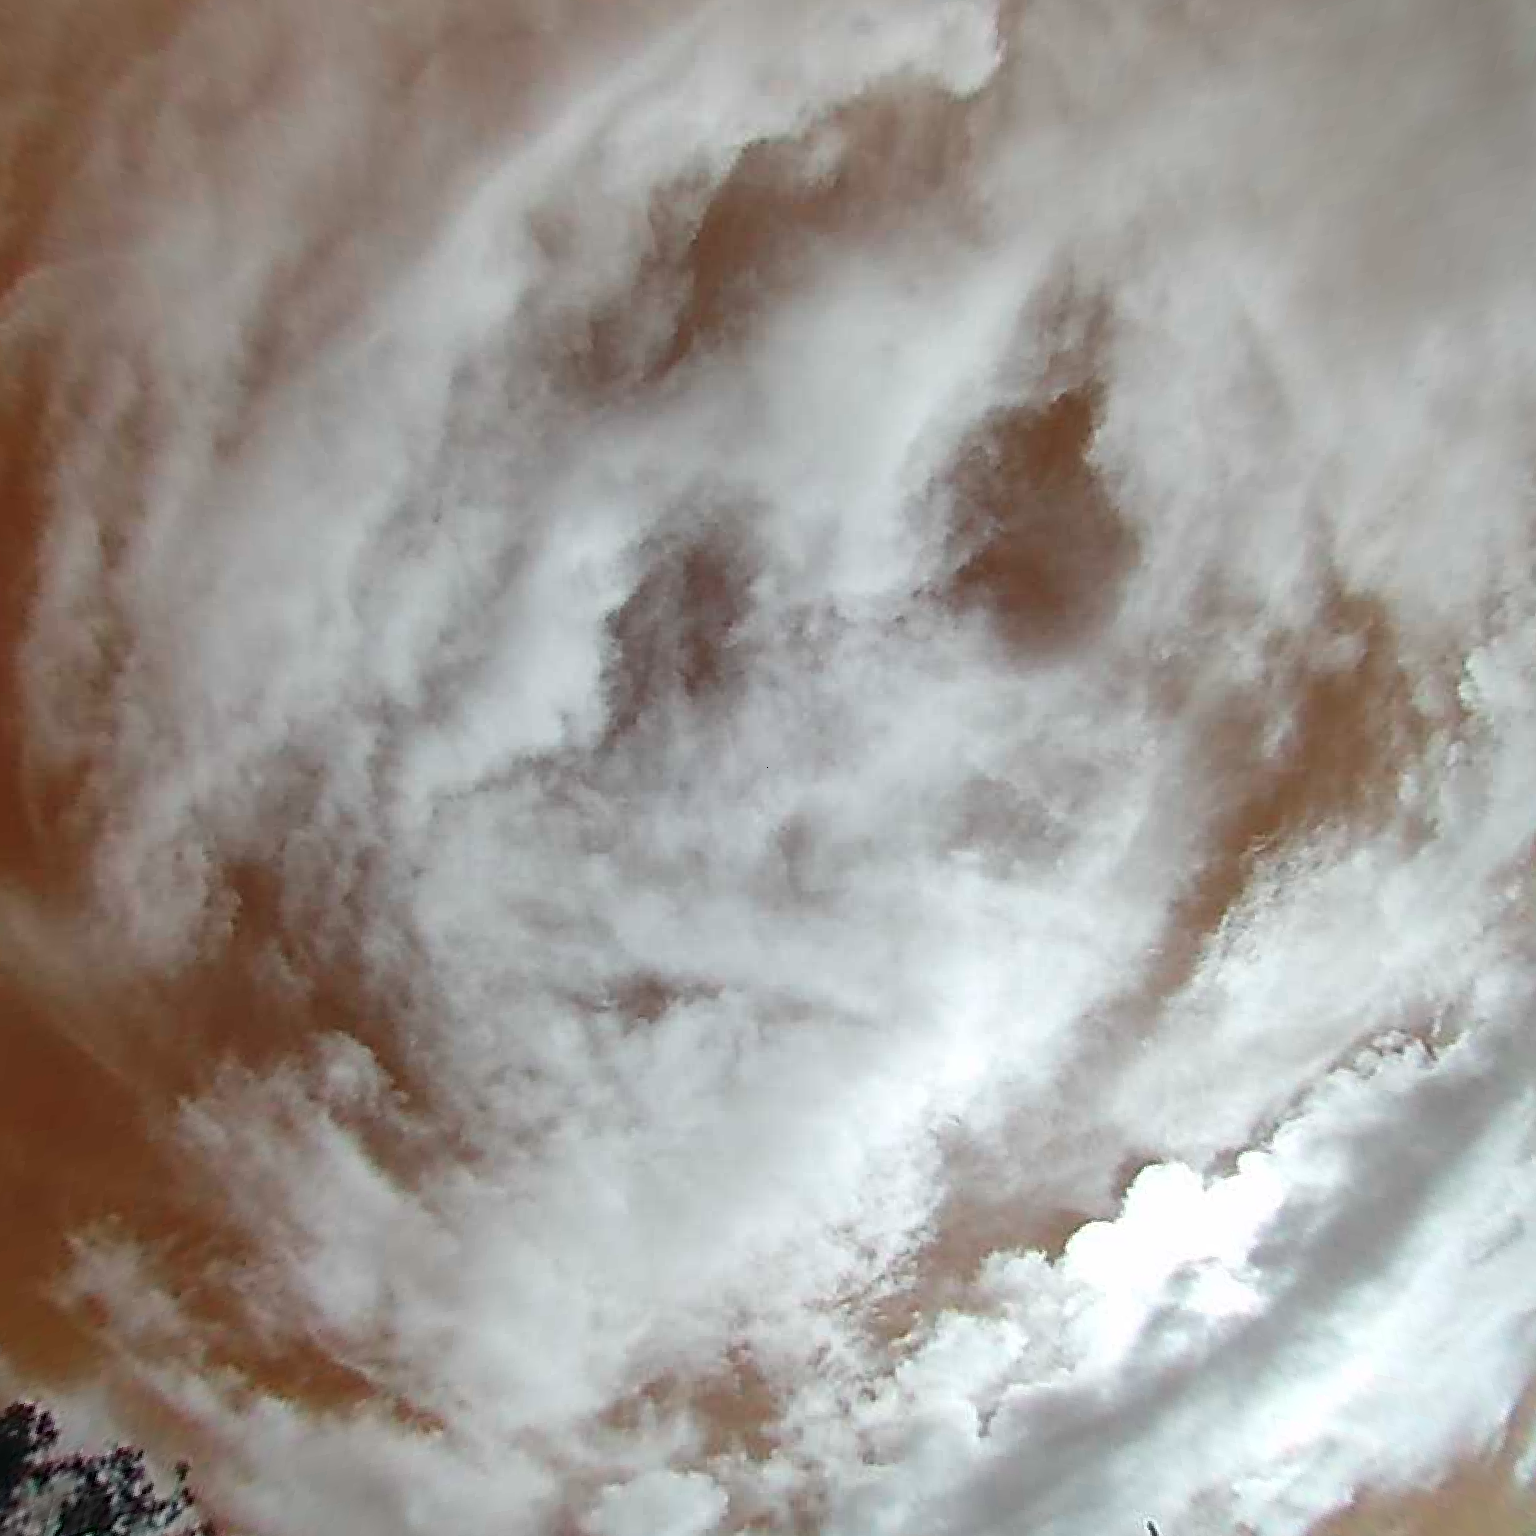

In [ ]:
# Color segmentation
color_seg = cv2.cvtColor(new_image, cv2.COLORMAP_RAINBOW )
cv2_imshow(color_seg)

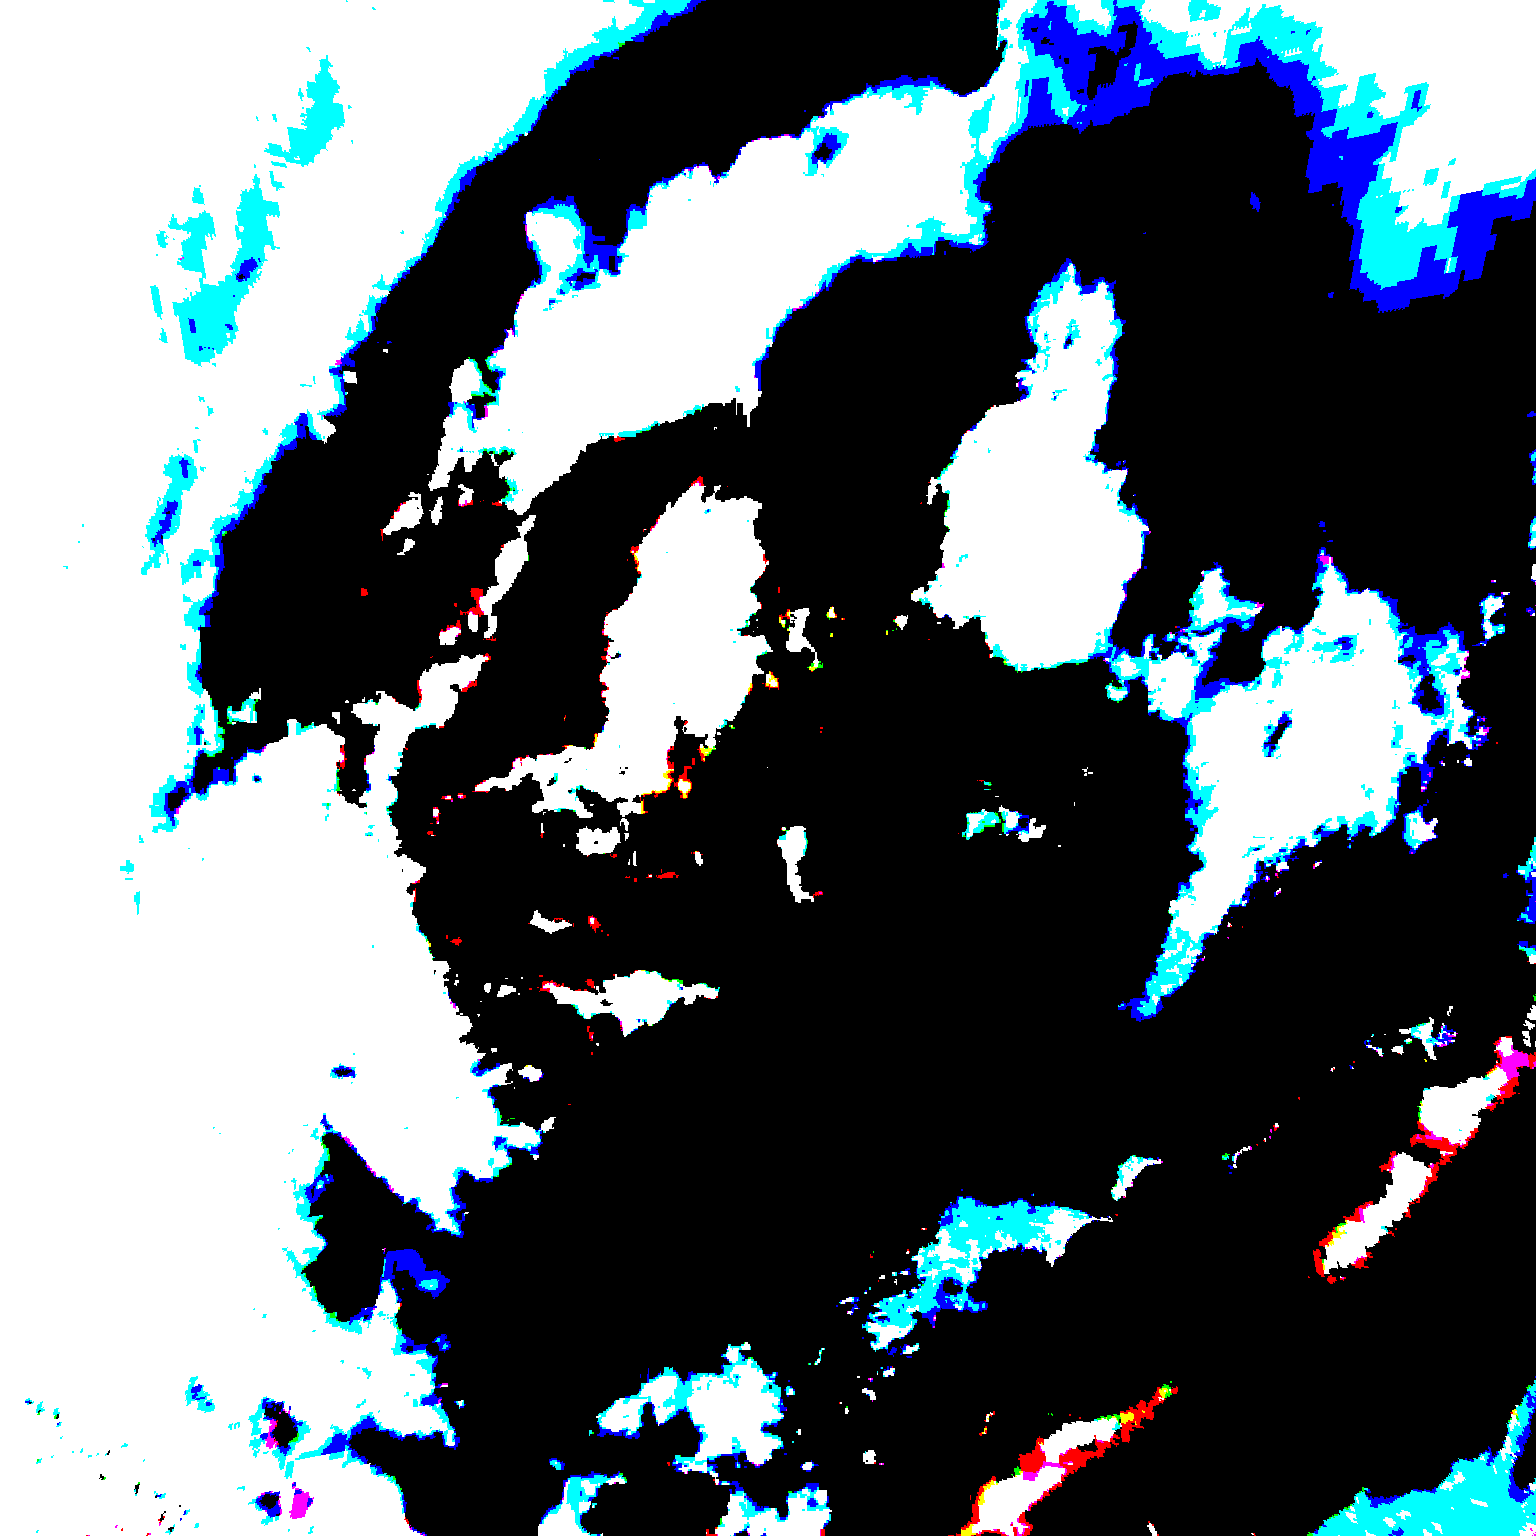

In [ ]:
ret3,cloud = cv.threshold(color_seg,150,255,cv.THRESH_BINARY)
cv2_imshow(cloud)

# Convert the cloud pixel to cloud cover

In [ ]:
cloud_pixel = len([i for i in cloud.flatten() if i <= 150])
total_pixel = len(cloud.flatten())

cloud_cover = (cloud_pixel/total_pixel)*100
cloud_cover

58.47550851327402

# Solar Position Detection

In [ ]:
gray = cv.cvtColor(new_image, cv.COLOR_BGR2GRAY)

rows = gray.shape[0]
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, rows / 8,
param1=100, param2=30,
minRadius=1, maxRadius=30)

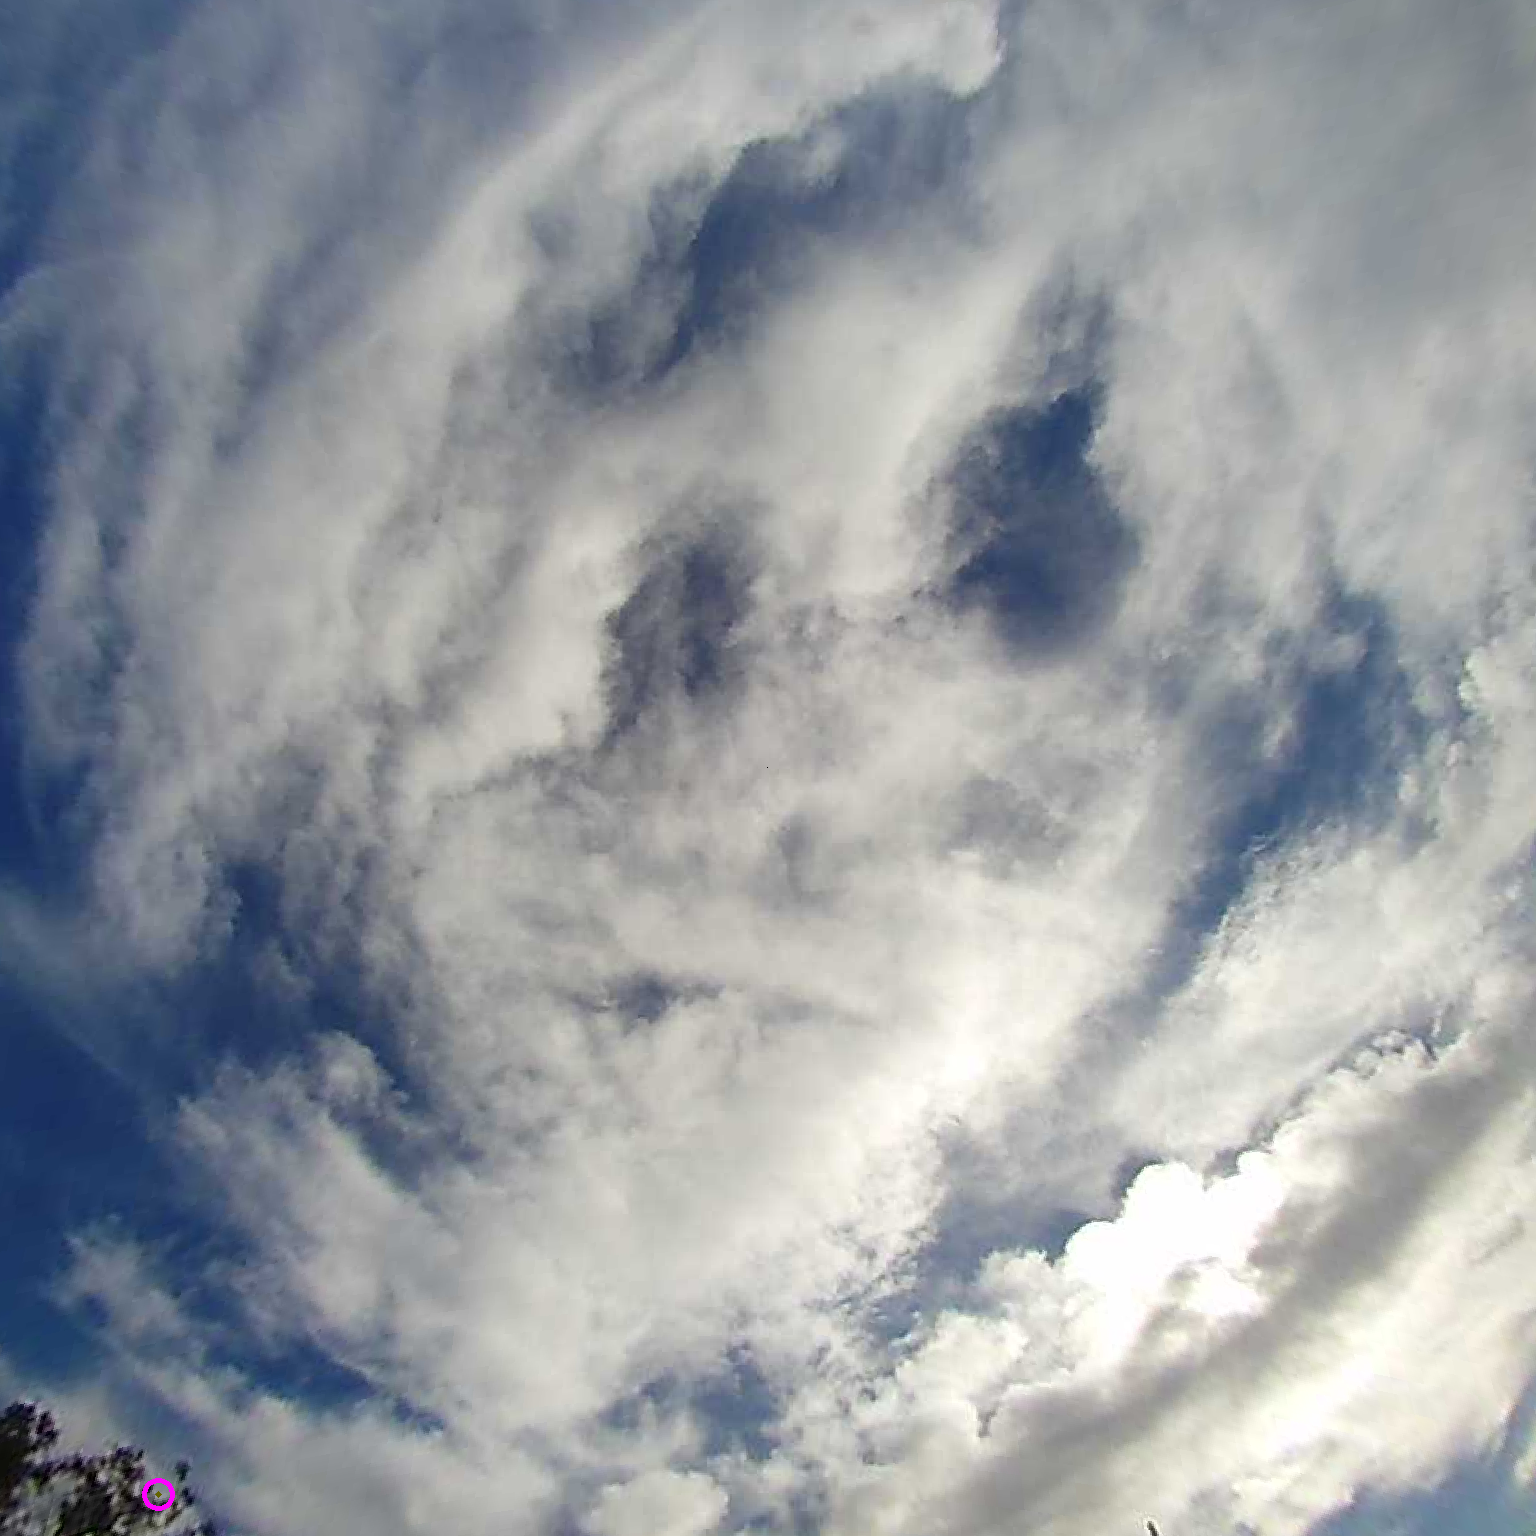

In [ ]:
if circles is not None:
  circles = np.uint16(np.around(circles))
  for i in circles[0, :]:
    center = (i[0], i[1])
    # circle center
    cv.circle(new_image, center, 1, (0, 100, 100), 3)
    # circle outline
    radius = i[2]
    cv.circle(new_image, center, radius, (255, 0, 255), 3)

cv2_imshow(new_image)
